# Classificação de incêndios florestais utilizando redes neurais convolucionais profundas e Transfer Learning 

<center><img src='https://media4.giphy.com/media/QKUx6kHItu3ilaVMdn/200.webp?cid=ecf05e47gics2m4k7lfvntuuwai9q63i175fusn61o163gvy&rid=200.webp&ct=s' height=300px width=300px></center>

O problema abordado é o de classificação de incêndios florestais, no qual nossa base de dados apresenta imagens de florestas com e sem fogo nelas de resolução 250x250.
A tarefa é relativamente simples, o modelo deve retornar se em uma dada imagem aparece um incêndio, ou não.

O modelo utilizado foi retirado de uma submissão do Kaggle para um problema idêntico ao nosso, mas com outra base de dados. O link para tal submissão é: 
https://www.kaggle.com/code/vencerlanz09/98-fire-classification-cnn-mobilenetv2/notebook



# 🏗️Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# set the dataset path correctly 
import glob
import cv2

images = [cv2.imread(file) for file in glob.glob("//content/drive/MyDrive/Mc886/Dataset/Dataset/Testing/fire.jpg")]

# 🤙Create helper functions

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-11-03 18:11:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-03 18:11:31 (50.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (250, 250)

In [6]:
# Walk through each directory
dataset = "/content/drive/MyDrive/Mc886/Dataset/Dataset/Training and Validation"
walk_through_dir(dataset)
dataset_test = "/content/drive/MyDrive/Mc886/Dataset/Dataset/Testing"
walk_through_dir(dataset_test)

There are 2 directories and 0 images in '/content/drive/MyDrive/Mc886/Dataset/Dataset/Training and Validation'.
There are 0 directories and 760 images in '/content/drive/MyDrive/Mc886/Dataset/Dataset/Training and Validation/nofire'.
There are 0 directories and 760 images in '/content/drive/MyDrive/Mc886/Dataset/Dataset/Training and Validation/fire'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Mc886/Dataset/Dataset/Testing'.
There are 0 directories and 190 images in '/content/drive/MyDrive/Mc886/Dataset/Dataset/Testing/fire'.
There are 0 directories and 190 images in '/content/drive/MyDrive/Mc886/Dataset/Dataset/Testing/nofire'.


# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [7]:
image_dir = Path(dataset)
image_dir_test = Path(dataset_test)

def data(dir):
# Get filepaths and labels
  filepaths = list(dir.glob(r'**/*.JPG')) + list(dir.glob(r'**/*.jpg')) + list(dir.glob(r'**/*.jpg'))

  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

  filepaths = pd.Series(filepaths, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
  return pd.concat([filepaths, labels], axis=1)
image_df = data(image_dir)
test_df =data(image_dir_test)


In [8]:
len(list(image_dir.glob(r'**/*.jpg')))

1520

In [9]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,nofire
1,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,nofire
2,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,nofire
3,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,nofire
4,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,nofire
...,...,...
3035,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,fire
3036,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,fire
3037,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,fire
3038,/content/drive/MyDrive/Mc886/Dataset/Dataset/T...,fire


# 🔭Visualizing images from the dataset

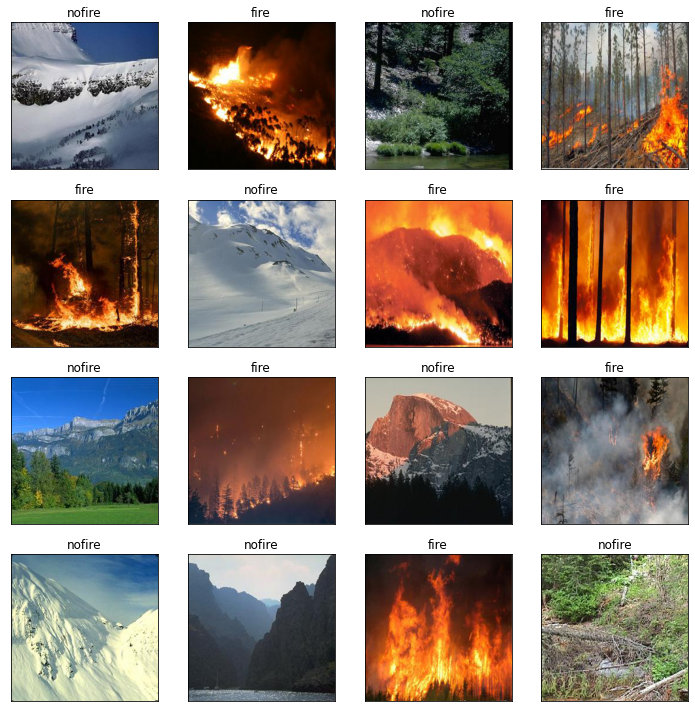

In [10]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2432 validated image filenames belonging to 2 classes.
Found 608 validated image filenames belonging to 2 classes.
Found 760 validated image filenames belonging to 2 classes.


In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# 🤹Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (320, 320, 3)

**Output layer** : 1



In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Training the model

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=25,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20221102-231832
Epoch 1/25
61/61 [==============================] - 97s 2s/step - loss: 0.2264 - accuracy: 0.9178 - val_loss: 0.0393 - val_accuracy: 0.9959
Epoch 2/25
61/61 [==============================] - 88s 1s/step - loss: 0.0396 - accuracy: 0.9902 - val_loss: 0.0171 - val_accuracy: 0.9979
Epoch 3/25
61/61 [==============================] - 91s 2s/step - loss: 0.0182 - accuracy: 0.9964 - val_loss: 0.0125 - val_accuracy: 0.9959
Epoch 4/25
61/61 [==============================] - 109s 2s/step - loss: 0.0109 - accuracy: 0.9974 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 5/25
61/61 [==============================] - 90s 1s/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 6/25
61/61 [==============================] - 91s 1s/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 7/25
61/61 [==============================] - 91s 1s/step - loss: 0.00

# ✔️Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00070
Test Accuracy: 100.00%


# 📉Visualizing loss curves

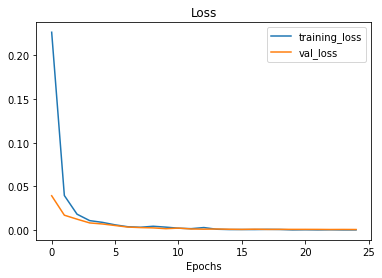

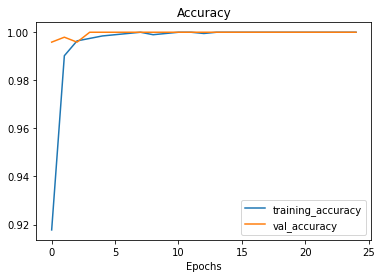

In [ ]:
plot_loss_curves(history)

# 🔮Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

19/19 [==============================] - 22s 1s/step
The first 5 predictions: ['nofire', 'fire', 'nofire', 'nofire', 'fire']


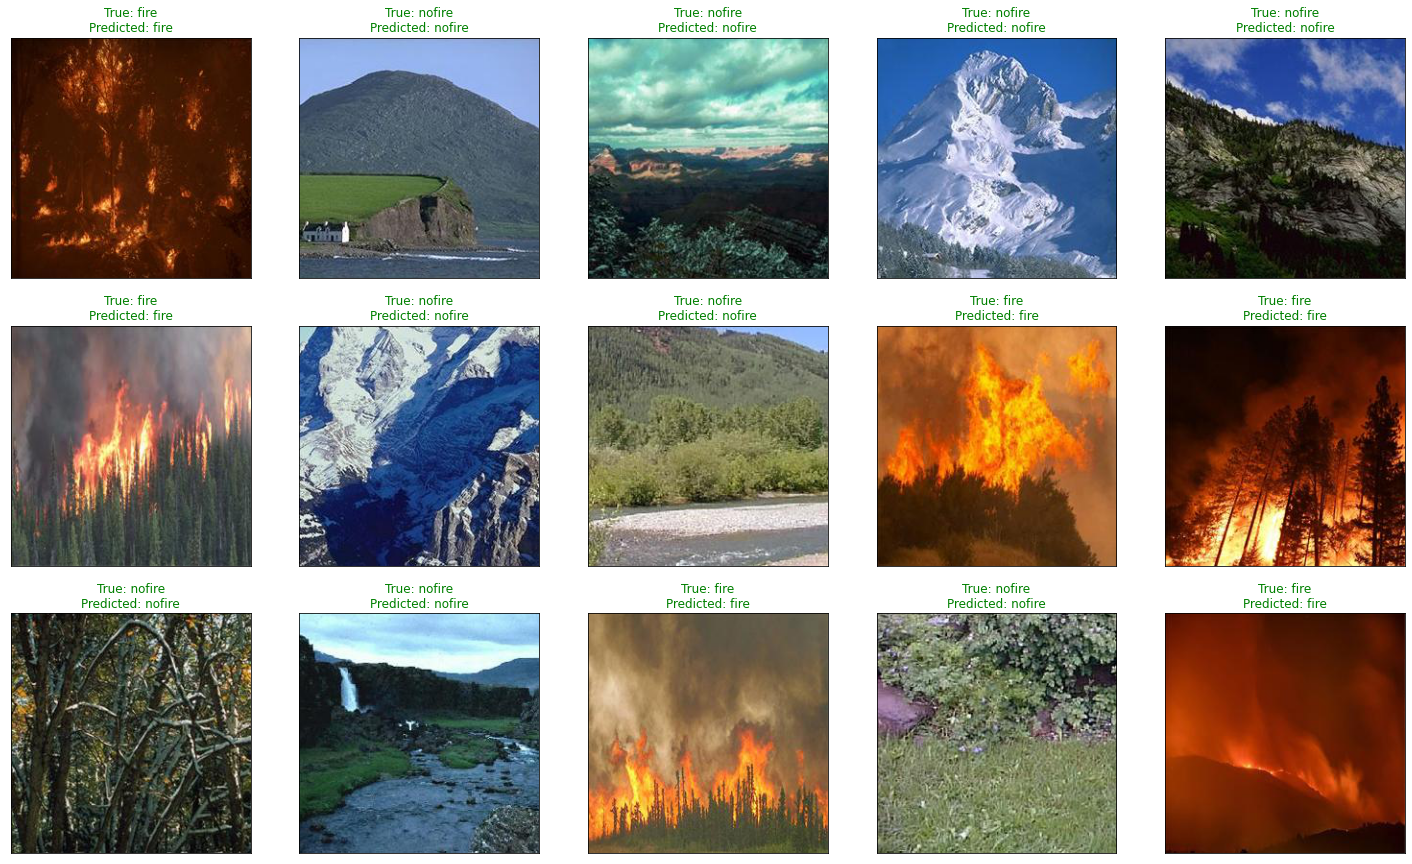

<Figure size 432x288 with 0 Axes>

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        fire       1.00      1.00      1.00       300
      nofire       1.00      1.00      1.00       308

    accuracy                           1.00       608
   macro avg       1.00      1.00      1.00       608
weighted avg       1.00      1.00      1.00       608



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire,1.0,1.0,1.0,300.0
nofire,1.0,1.0,1.0,308.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,608.0
weighted avg,1.0,1.0,1.0,608.0


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


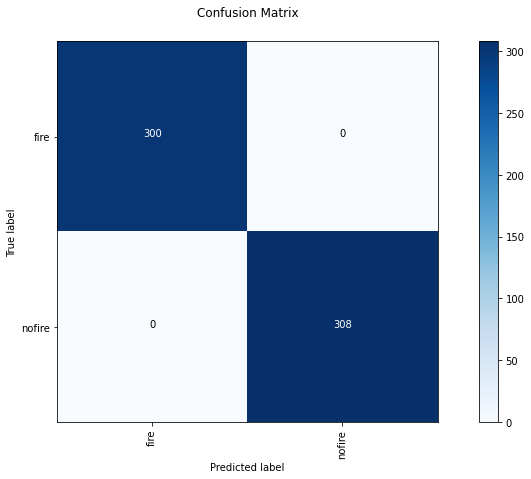

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

Como se pode observar, nossa acurácia nos dados de teste foi de 100%, o que é espantoso, tendo em vista que utilizamos o modelo sem realizar nenhuma alteração significativa nele. Tendo isso em vista, podemos observar o poder adaptativo do transfer learning, que com poucas iterações já obteve uma enorme acurácia no treino e validação. Além disso, o número de imagens utilizado parece ser o suficiente para treinar nossa rede, pelo sucesso obtido no teste.

Entretanto, pelo enorme sucesso do modelo em sua tarefa, levantou-se o questionamento se nosso problema não é simples demais, se por termos utilizado uma base de dados "limpa" (sem pessoas, máquinas e outras coisas que não fazem parte do problema) não facilitamos em excesso o estudo. Sendo assim, é possível que nossa base de dados não seja representativa da realidade, e nosso modelo, apesar de estar funcionando muito bem no teste, ser insuficiente na 'vida real'.

Assim, nosso próximo passo é pensar em como aumentar a complexidade de nossa base de dados para obtermos um modelo mais representativo da realidade. Uma forma de se obter isso seria aumentar nossa base de dados com outros dados não tão "limpos".